In [0]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from time import sleep
import datetime
import bs4
import json 


def clean_string(column):
    return column.apply(lambda x: x.replace("\n",'',2)).apply(lambda x: x.replace('  ',''))

def scrape_reviews(PATH, n_pages, sleep_time = 0.3):


    names = []
    ratings = []
    headers = []
    reviews = []
    dates = []
    locations = []

    for p in range(18):

        sleep(sleep_time)

        #http = requests.get(f'{PATH}{p}&stars=1&stars=5')
        x= PATH+str(p+1)
       
        r = requests.get(x)
         
        bsoup = BeautifulSoup(r.text, 'html.parser')
        base_url = 'https://fr.trustpilot.com/review/mcdonalds.fr'

        review_containers = bsoup.find_all('div', class_ = 'review-content__body')
        user_containers = bsoup.find_all('div', class_ = 'consumer-information__name')
        rating_container = bsoup.find_all('div', class_="star-rating star-rating--medium")      
       
        profile_link_containers = bsoup.find_all('aside', class_ = 'review__consumer-information' )
        
        for x in range(len(bsoup.find_all('div', class_ = 'review-content'))):
            
            review_c = review_containers[x]
            headers.append(review_c.h2.a.text)
            
            if type(review_c.p) == bs4.element.Tag:
                reviews.append(review_c.p.text)
            else :
                reviews.append("")
            reviewer = user_containers[x]
          
            rating = rating_container[x]
            ratings.append( "\n".join([img['alt'] for img in rating.find_all('img', alt=True)]).replace(" étoile :","").replace(" étoiles :",""))
            
           
            
            prof = profile_link_containers[x]
            link = 'https://www.trustpilot.com'+ prof.a['href']
            c_profile = requests.get(f'{link}')
            csoup = BeautifulSoup(c_profile.text, 'html.parser')
            cust_container = csoup.find('div', class_ = 'user-summary-location')
            locations.append(cust_container.text)
    
        for star in  bsoup.find_all('div', class_ = 'review-content'):
          
        # Get date value
          date_json = json.loads(star.find('script').text)
          date = date_json['publishedDate']
          dates.append(date)

    rev_df = pd.DataFrame(list(zip( headers, reviews, ratings, ratings, dates, locations)),
                  columns = ['Header','Review','Rating','Mention','Date', 'Location'])
    
    print(len(bsoup.find_all('div', class_ = 'review-content')))
    
    rev_df.Review = clean_string(rev_df.Review)
    rev_df.Location = clean_string(rev_df.Location)
    rev_df.Location = rev_df.Location.apply(lambda x: x.split(',',1)[-1])
    rev_df.Rating = rev_df.Rating.str[:1]  
    rev_df.Mention = rev_df.Mention.str[2:] 
    rev_df.Date = rev_df.Date.str[:10] 
    return rev_df

In [0]:
df = scrape_reviews(PATH = 'https://fr.trustpilot.com/review/mcdonalds.fr?page=',
                   n_pages = 18)

4


In [0]:
df

,Header,Review,Rating,Mention,Date,Location
0,Le Macdo de Tournon/Rhône est NUL !!,Le Macdo de Tournon/Rhône est NUL !!! Toujours...,1,mauvais,2020-05-02,France
1,Bon mais de plus en plus cher ..,,4,bien,2020-05-01,France
2,Conditions d'emploi indécent,Ils remploient leurs employés sans respecter l...,1,mauvais,2020-04-23,France
3,Les McDonald's en France sont pour la…,Les McDonald's en France sont pour la plupart ...,4,bien,2020-04-02,France
4,Responsable Mc Do hautain,"Bonjour, Je me suis rendu au Mc Do du centre c...",1,mauvais,2020-03-18,France
...,...,...,...,...,...,...
339,Mon fast-food préféré,"J'aime beaucoup aller chez McDonald, surtout q...",4,bien,2016-03-28,France
340,Degueulasse,"Dégueulasse ! Frites immonde, service lent.Le ...",1,mauvais,2015-09-08,France
341,genial a part les sodas,c est sympa surtout pour que les enfants puiss...,5,excellent,2015-07-03,Malta
342,pas toujours de glace,"Effectivement, rarement de la glace le soir..",4,bien,2014-07-25,France


In [0]:
df.to_csv('C:\\Users\\Asus\\Desktop\\pp.csv')

In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim
import spacy
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import gensim.models 

# NLTK Stop words
from nltk.corpus import stopwords
#from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop 
stop_words = stopwords.words('french')
stop_words.extend(['ca', 'ete','donc','apres','tout','cest','quand','très','ça','daller','plus','do','fois','plus','car','tous','alors','tres','lors','faire','sans','dautre','nest','encore','comment','choose','prendre','arrive','meme','avant','etaient','ver','meet','toute','vraiment','toujour','tient','dire','quelque','fait','renverse'])
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [0]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['le', 'macdo', 'de', 'tournon', 'rhone', 'est', 'nul', 'toujours', 'des', 'produits', 'manquants', 'fois', 'sur', 'autant', 'pour', 'le', 'surplace', 'que', 'pour', 'emporter', 'attente', 'interminable', 'la', 'caisse', 'pour', 'demander', 'quelque', 'chose', 'je', 'nai', 'vu', 'ceci', 'seulement', 'tournon', 'rhone', 'davezieux', 'ou', 'bourg', 'les', 'valence', 'je', 'nai', 'jamais', 'eu', 'de', 'produits', 'manquants', 'tournon', 'rhone', 'il', 'veut', 'prendre', 'les', 'clients', 'pour', 'des', 'imbeciles', 'jai', 'decide', 'daller', 'ailleurs', 'les', 'restaurants', 'sont', 'equivalents', 'cote', 'prix', 'mais', 'cote', 'responsable', 'pointe', 'pour', 'les', 'macdo']]


In [0]:

!python3 -m spacy download fr_core_news_sm

     |████████████████████████████████| 14.7MB 734kB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp36-none-any.whl size=14727027 sha256=83911e31f4dd25d938a7ec03363c5b34f8bf5929eff92b54546d6be7e1e04e3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wa50zaji/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [0]:
import fr_core_news_sm
nlp = fr_core_news_sm.load()


In [0]:
# Build the bigram and trigram models
from nltk.stem.snowball import FrenchStemmer
Stemmer = FrenchStemmer()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = fr_core_news_sm.load()
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([Stemmer.stem(token.text) for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
print(data_ready)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


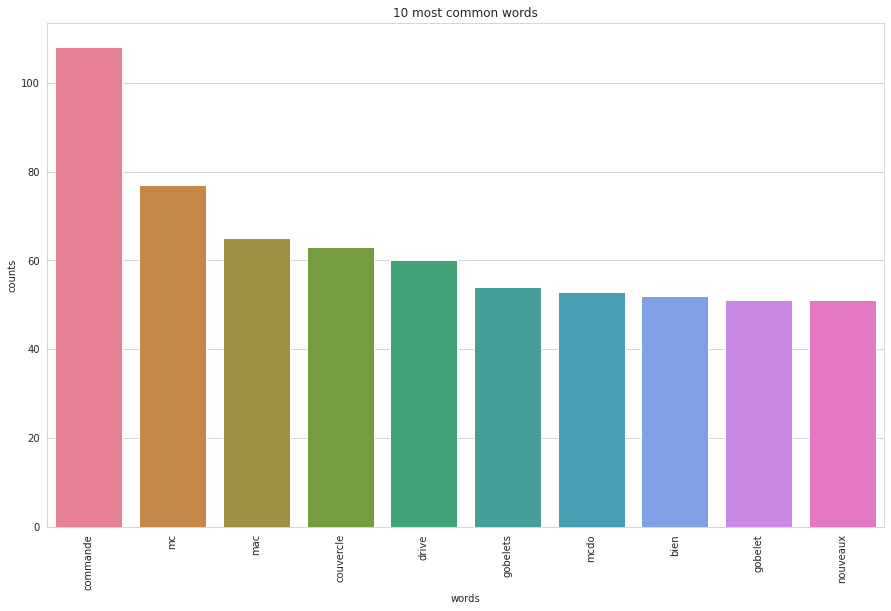

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words )
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)




In [0]:
# Create Dictionary
from gensim import corpora, models
id2word = corpora.Dictionary(data_ready)
id2word.filter_extremes(no_below=7, no_above=0.8, keep_n=1000000)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=70,
                                           update_every=1,
                                           chunksize=20,
                                           passes=100,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.127*"enfant" + 0.060*"couvercl" + 0.040*"voir" + 0.037*"desagre" + '
  '0.037*"bouch" + 0.035*"pir" + 0.033*"main" + 0.030*"petit" + 0.030*"fil" + '
  '0.029*"met"'),
 (1,
  '0.034*"servic" + 0.031*"froid" + 0.030*"frit" + 0.025*"nul" + '
  '0.025*"burger_king" + 0.024*"paill" + 0.023*"minut" + 0.023*"nouveau" + '
  '0.023*"temp" + 0.022*"bon"'),
 (2,
  '0.039*"glac" + 0.034*"command" + 0.024*"soir" + 0.023*"driv" + 0.021*"pass" '
  '+ 0.021*"restaur" + 0.021*"demand" + 0.020*"tabl" + 0.019*"personnel" + '
  '0.017*"mcdo"'),
 (3,
  '0.062*"mang" + 0.046*"person" + 0.041*"hont" + 0.036*"dej" + 0.031*"cuisin" '
  '+ 0.027*"pratiqu" + 0.026*"manag" + 0.026*"compt" + 0.025*"travaill" + '
  '0.024*"toilet"')]


In [0]:
num_topic=4
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);
get_lda_topics(lda_model, num_topic)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,enfant,servic,glac,mang
1,couvercl,froid,command,person
2,voir,frit,soir,hont
3,desagre,nul,driv,dej
4,bouch,burger_king,pass,cuisin
5,pir,paill,restaur,pratiqu
6,main,minut,demand,manag
7,petit,nouveau,tabl,compt
8,fil,temp,personnel,travaill
9,met,bon,mcdo,toilet


In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic i each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7533,"glac, command, soir, driv, pass, restaur, dema...","[macdo, tournon, rhon, nul, produit, manqu, em..."
1,1,0.0,0.2500,"enfant, couvercl, voir, desagre, bouch, pir, m...",[]
2,2,0.0,0.2500,"enfant, couvercl, voir, desagre, bouch, pir, m...","[employ, respect, mesur, vigueur, concern, covid]"
3,3,1.0,0.9057,"servic, froid, frit, nul, burger_king, paill, ...","[mcdonald, plupart, propr, servic, rapid, prix..."
4,4,2.0,0.5861,"glac, command, soir, driv, pass, restaur, dema...","[bonjour, rendu, centr, commercial, montpelli,..."
5,5,0.0,0.4106,"enfant, couvercl, voir, desagre, bouch, pir, m...","[coron, virus, met, vi, salar, dang, etait, in..."
6,6,0.0,0.3247,"enfant, couvercl, voir, desagre, bouch, pir, m...","[attend, minj, command, poisson, recu, poisson..."
7,7,2.0,0.7734,"glac, command, soir, driv, pass, restaur, dema...","[bonjour, mc, danet, inadmissibl, pai, sauc, p..."
8,8,2.0,0.8079,"glac, command, soir, driv, pass, restaur, dema...","[mcdonald, claqu, boit, baign, salad, fromag, ..."
9,9,0.0,0.8149,"enfant, couvercl, voir, desagre, bouch, pir, m...","[bel, mouis, pol, couvercl, tiennent, port, bo..."


In [0]:
Aspect =pd.DataFrame(pd.cut(df_dominant_topic['Dominant_Topic'],bins=[-1,0,1,2,3],labels=['Restaurant en general ','Service','Commande/drive','Nourriture']))

Aspect.columns=["Aspect"]


In [0]:
result = pd.concat([df, Aspect], axis=1)
result.head(10)

,Header,Review,Rating,Mention,Date,Location,Aspect
0,Le Macdo de Tournon/Rhône est NUL !!,Le Macdo de Tournon/Rhône est NUL !!! Toujours...,1,mauvais,2020-05-02,France,Commande/drive
1,Bon mais de plus en plus cher ..,,4,bien,2020-05-01,France,Restaurant en general
2,Conditions d'emploi indécent,Ils remploient leurs employés sans respecter l...,1,mauvais,2020-04-23,France,Restaurant en general
3,Les McDonald's en France sont pour la…,Les McDonald's en France sont pour la plupart ...,4,bien,2020-04-02,France,Service
4,Responsable Mc Do hautain,"Bonjour, Je me suis rendu au Mc Do du centre c...",1,mauvais,2020-03-18,France,Commande/drive
5,Corona virus,"Corona virus, Macdonald met la vie de ses sala...",1,mauvais,2020-03-16,France,Restaurant en general
6,Éviter McDo peipin,Attende de plus de 15minJ’ai commander 3mcfies...,1,mauvais,2020-03-14,France,Restaurant en general
7,Mc do Anet,Bonjour Mc do d'Anet je trouve sa inadmissible...,1,mauvais,2020-03-14,France,Commande/drive
8,McDonald's Chauconin 77124,McDonald's Chauconin 77124CBO claqué vulgairem...,3,moyen,2020-03-12,France,Commande/drive
9,Impossible,Une belle mouise en restant polie ! Ces nvx co...,1,mauvais,2020-03-10,France,Restaurant en general


In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8500,"enfant, couvercl, voir, desagre, bouch, pir, main, petit, fil, met","[verr, naz, tiennent, renverseet, sensat, fibr, bouch, desagre, beurk]"
1,1.0,0.9361,"servic, froid, frit, nul, burger_king, paill, minut, nouveau, temp, bon","[mac, donald, autorout, dimanch, decembr, attendr, heur, dem, command, serv, numeros, posterieur..."
2,2.0,0.9603,"glac, command, soir, driv, pass, restaur, demand, tabl, personnel, mcdo","[mcdonald, froideconch, franch, comt, lund, decembr, passon, driv, copain, dis, menu, copain, me..."
3,3.0,0.8125,"mang, person, hont, dej, cuisin, pratiqu, manag, compt, travaill, toilet","[pratiqu, impossibl, rempl, enlev]"


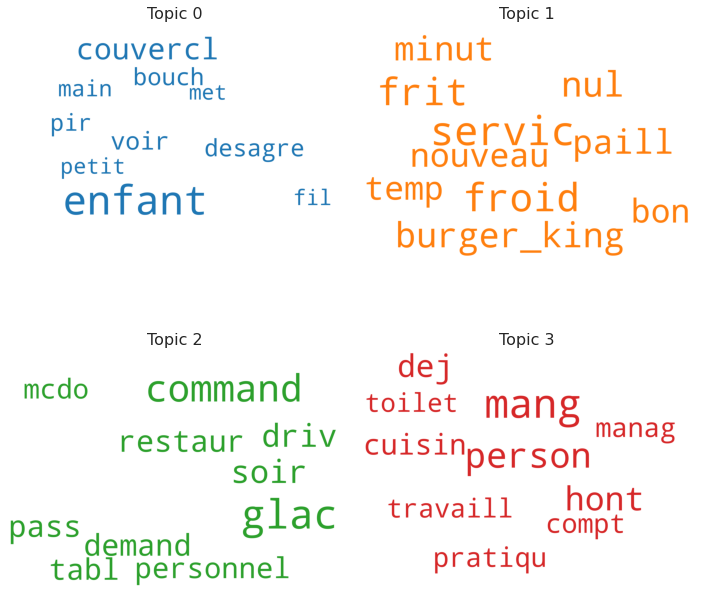

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

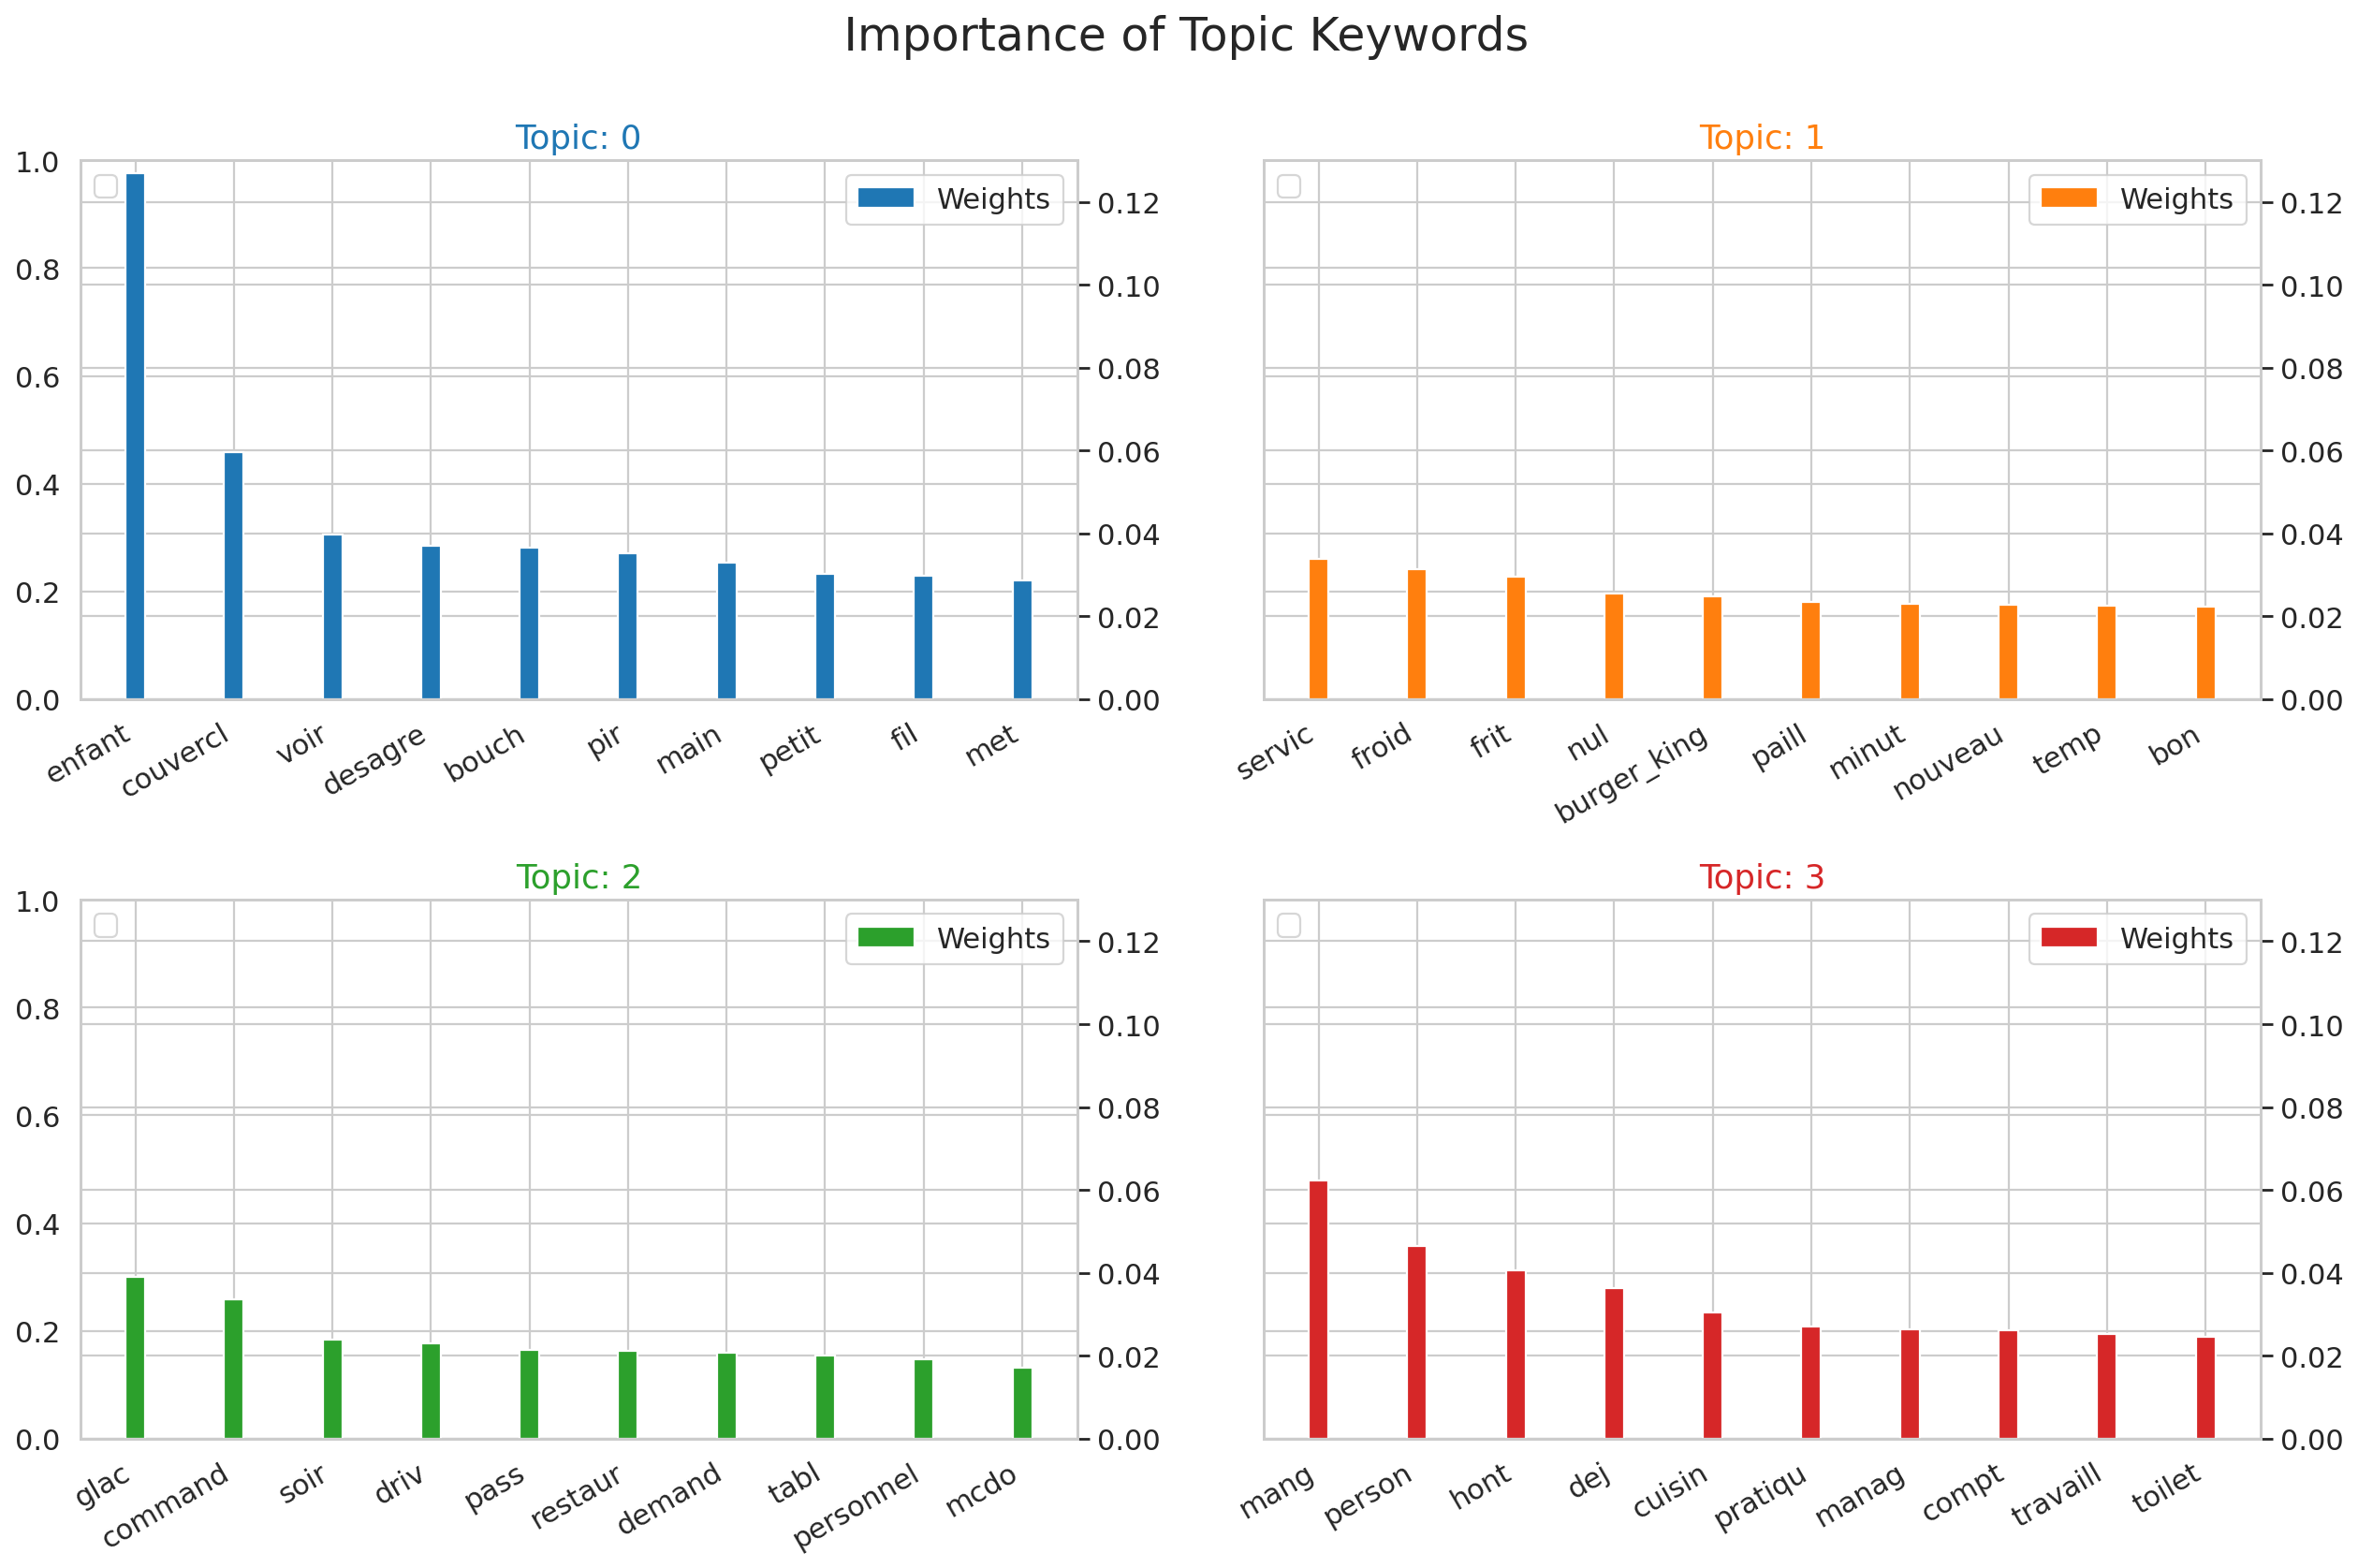

In [0]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    #ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    #ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.13); 
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle(' Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

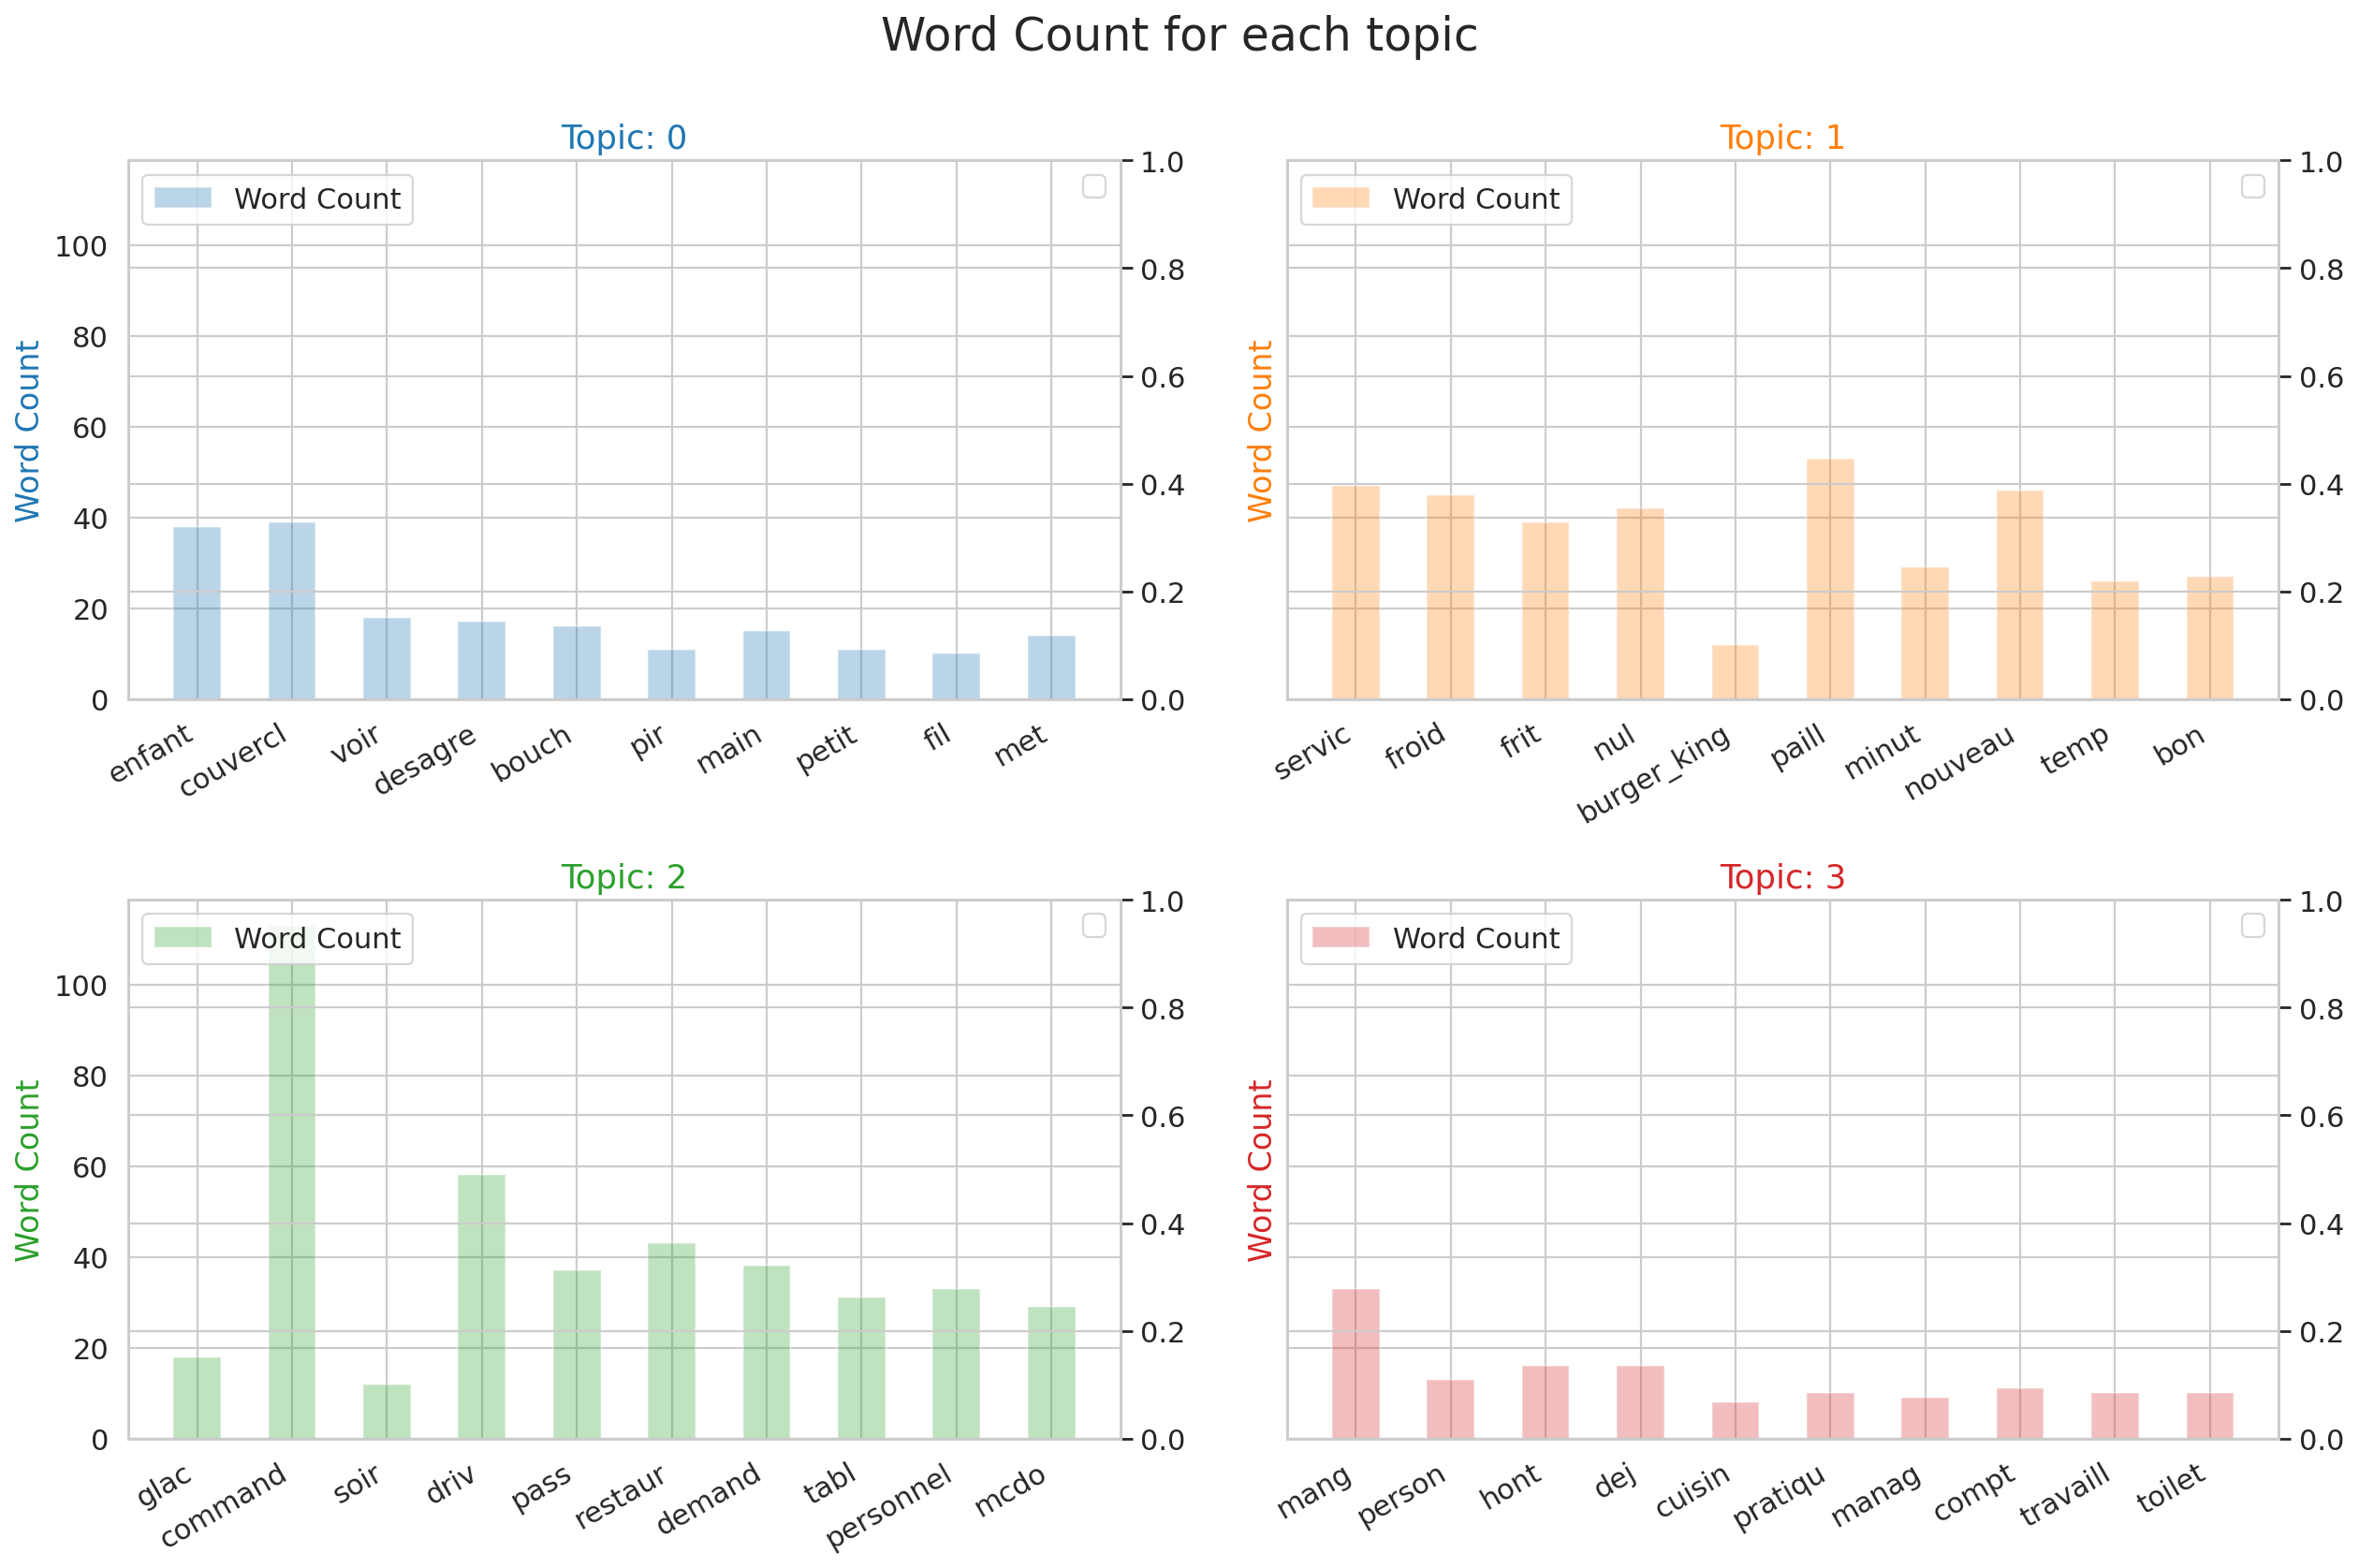

In [0]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    #ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count for each topic', fontsize=22, y=1.05)    
plt.show()

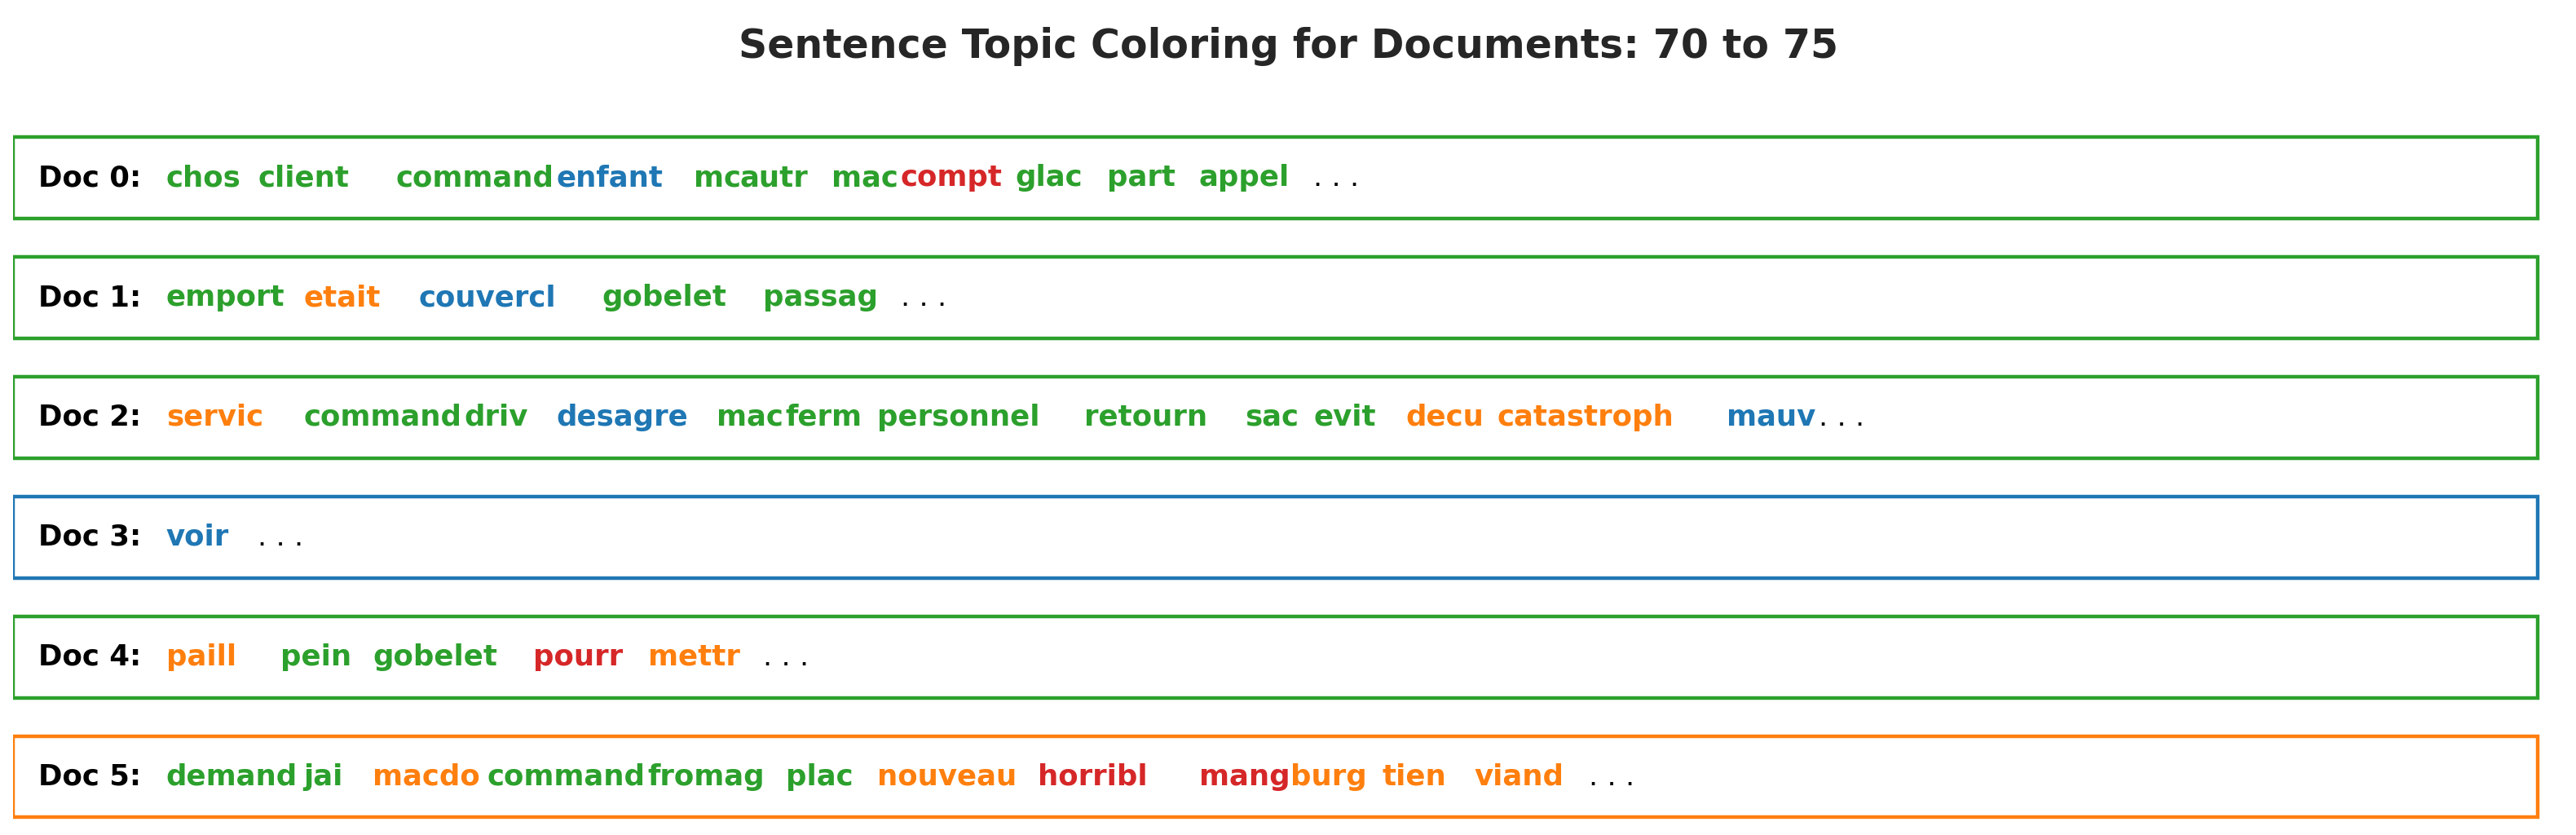

In [0]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus_tfidf, start = 70, end = 77):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

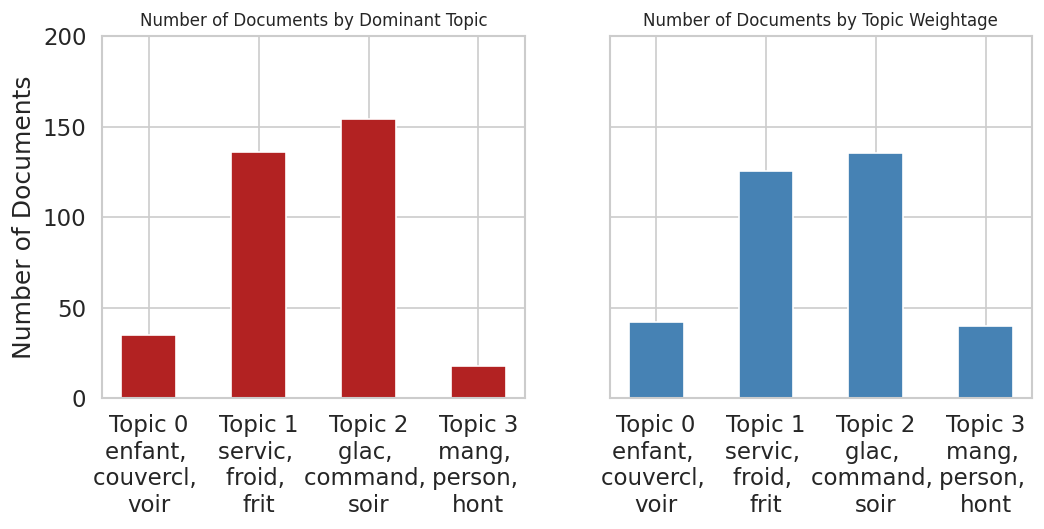

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [0]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics[:3]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"glac, command, soir, driv, pass, restaur, demand, tabl, personnel, mcdo",35.0,0.1017
1.0,0.0,"enfant, couvercl, voir, desagre, bouch, pir, main, petit, fil, met",136.0,0.3953
2.0,0.0,"enfant, couvercl, voir, desagre, bouch, pir, main, petit, fil, met",155.0,0.4506
3.0,1.0,"servic, froid, frit, nul, burger_king, paill, minut, nouveau, temp, bon",18.0,0.0523


In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.194374  0.144331       1        1  43.437935
1      0.229011  0.104748       2        1  36.063187
3     -0.023004 -0.102755       3        1  10.312115
0     -0.011632 -0.146323       4        1  10.186761, topic_info=         Term       Freq      Total Category  logprob  loglift
24     enfant  43.000000  43.000000  Default  30.0000  30.0000
128      mang  22.000000  22.000000  Default  29.0000  29.0000
51   couvercl  21.000000  21.000000  Default  28.0000  28.0000
100    person  17.000000  17.000000  Default  27.0000  27.0000
120      hont  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
93       ferm   0.691484  12.096334   Topic4  -6.1457  -0.5777
41      paill   0.742472  29.144794   Topic4  -6.0745  -1.3860
156      tien   0.709537  17.165642   Topic4  -6.1199  -0.9020
26       driv   0.734356  33.954350   Topic4  -6.0855  -1.5497
36      grand   0.703097  15.612212   Topic4  -6.1290  -0.8162

[173 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
101       1  0.741629  aimabl
101       2  0.052973  aimabl
101       3  0.211894  aimabl
101       4  0.052973  aimabl
74        1  0.878521   aller
...     ...       ...     ...
98        4  0.039058  voitur
132       1  0.040740    vrai
132       2  0.896274    vrai
132       3  0.040740    vrai
132       4  0.040740    vrai

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [0]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 20.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=f756fc21df2d039e86e3f902bee15a1631afe23c8b7c4de016e38b23700bb7eb
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=af172e63ca313c7048a91b7ffeb30b8c7b4a8256d789d4039df2df6e6f09ccc1
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


##  Topic modeling with NMF

In [0]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In [0]:
train_headlines_sentences = [' '.join(text) for text in data_ready]

In [0]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(train_headlines_sentences);

In [0]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [0]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)


In [0]:
#obtain a NMF model.
model = NMF(n_components=4, init='nndsvd',shuffle=True);
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=None, shuffle=True, solver='cd', tol=0.0001,
    verbose=0)

In [0]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(4):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [0]:
get_nmf_topics(model,10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,froid,gobelet,couvercl,fast
1,hamburger,nettoi,nul,attent
2,different,paill,emport,inadmissibl
3,dommag,voitur,temp,grand
4,mcdonald,mettr,paill,chos
5,frit,bouchon,voitur,minut
6,long,sac,nouveau,prix
7,command,version,boisson,restaur
8,present,attrap,boir,zen
9,mac,bordel,merc,dedan


In [0]:
####################################### NEXT STEP OF OPINION MINING ###########################################

In [0]:
result.head(10)

,Header,Review,Rating,Mention,Date,Location,Aspect
0,Le Macdo de Tournon/Rhône est NUL !!,Le Macdo de Tournon/Rhône est NUL !!! Toujours...,1,mauvais,2020-05-02,France,Commande/drive
1,Bon mais de plus en plus cher ..,,4,bien,2020-05-01,France,Restaurant en general
2,Conditions d'emploi indécent,Ils remploient leurs employés sans respecter l...,1,mauvais,2020-04-23,France,Restaurant en general
3,Les McDonald's en France sont pour la…,Les McDonald's en France sont pour la plupart ...,4,bien,2020-04-02,France,Service
4,Responsable Mc Do hautain,"Bonjour, Je me suis rendu au Mc Do du centre c...",1,mauvais,2020-03-18,France,Commande/drive
5,Corona virus,"Corona virus, Macdonald met la vie de ses sala...",1,mauvais,2020-03-16,France,Restaurant en general
6,Éviter McDo peipin,Attende de plus de 15minJ’ai commander 3mcfies...,1,mauvais,2020-03-14,France,Restaurant en general
7,Mc do Anet,Bonjour Mc do d'Anet je trouve sa inadmissible...,1,mauvais,2020-03-14,France,Commande/drive
8,McDonald's Chauconin 77124,McDonald's Chauconin 77124CBO claqué vulgairem...,3,moyen,2020-03-12,France,Commande/drive
9,Impossible,Une belle mouise en restant polie ! Ces nvx co...,1,mauvais,2020-03-10,France,Restaurant en general


10.0
10.0


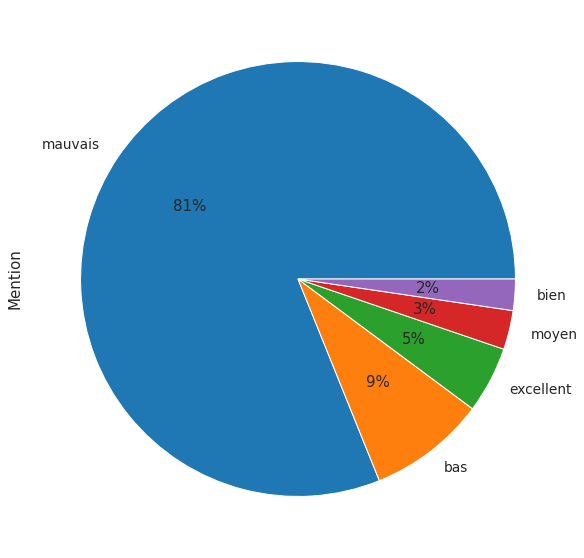

In [0]:
import matplotlib.pyplot as plt

plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 10
plot_size[1] = 10
plt.rcParams["figure.figsize"] = plot_size 
result.Mention.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [0]:

list2=[]

for line in result['Rating']:   
    if line in ["1","2"]:
      list2.append("negative")
    elif line =="3":
      list2.append("neutre")
    else :
       list2.append("positive")

            


In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.6MB/s 


In [0]:
sentiment= pd.DataFrame(list2)
sentiment.columns=["sentiment"]
resultFinal = pd.concat([result, sentiment], axis=1)
resultFinal.head(10)

,Header,Review,Rating,Mention,Date,Location,Aspect,sentiment
0,Le Macdo de Tournon/Rhône est NUL !!,Le Macdo de Tournon/Rhône est NUL !!! Toujours...,1,mauvais,2020-05-02,France,Commande/drive,negative
1,Bon mais de plus en plus cher ..,,4,bien,2020-05-01,France,Restaurant en general,positive
2,Conditions d'emploi indécent,Ils remploient leurs employés sans respecter l...,1,mauvais,2020-04-23,France,Restaurant en general,negative
3,Les McDonald's en France sont pour la…,Les McDonald's en France sont pour la plupart ...,4,bien,2020-04-02,France,Service,positive
4,Responsable Mc Do hautain,"Bonjour, Je me suis rendu au Mc Do du centre c...",1,mauvais,2020-03-18,France,Commande/drive,negative
5,Corona virus,"Corona virus, Macdonald met la vie de ses sala...",1,mauvais,2020-03-16,France,Restaurant en general,negative
6,Éviter McDo peipin,Attende de plus de 15minJ’ai commander 3mcfies...,1,mauvais,2020-03-14,France,Restaurant en general,negative
7,Mc do Anet,Bonjour Mc do d'Anet je trouve sa inadmissible...,1,mauvais,2020-03-14,France,Commande/drive,negative
8,McDonald's Chauconin 77124,McDonald's Chauconin 77124CBO claqué vulgairem...,3,moyen,2020-03-12,France,Commande/drive,neutre
9,Impossible,Une belle mouise en restant polie ! Ces nvx co...,1,mauvais,2020-03-10,France,Restaurant en general,negative


sentiment
negative    309
positive     25
neutre       10
dtype: int64


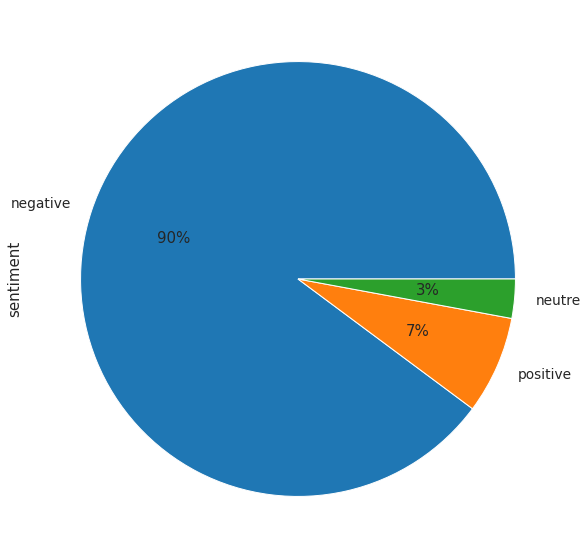

In [262]:
print(sentiment.groupby('sentiment').size().sort_values(ascending=False))
resultFinal.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

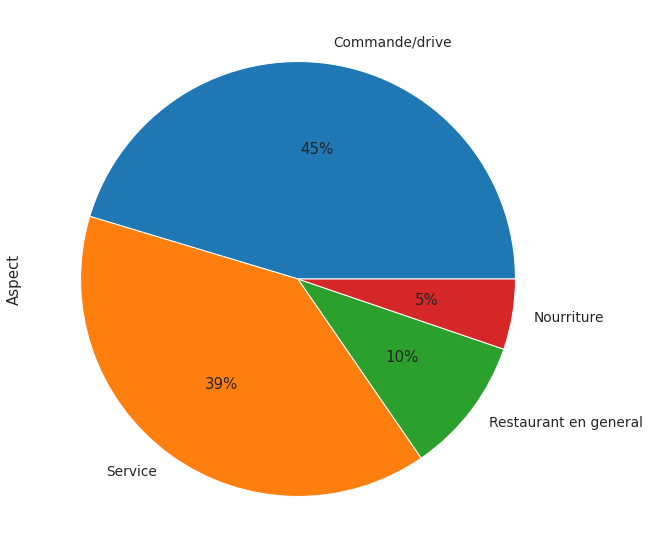

In [263]:
resultFinal.Aspect.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [0]:
# reviews_train.columns
print(resultFinal.groupby('Aspect').size().sort_values(ascending=False))

#how many categories
print("number of categories",resultFinal.Aspect.nunique())

Aspect
Commande/drive            156
Service                   135
Restaurant en general      35
Nourriture                 18
dtype: int64
number of categories 4


In [0]:
resultFinalWork=resultFinal


In [0]:
!python3 -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6MB 1.2MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338488 sha256=23793f66aae0d3076cb5ab282905df85742d897f91f504f3f012ae43328c8833
  Stored in directory: /tmp/pip-ephem-wheel-cache-rqe2sjds/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


### ***TRY AMA BAED BICH NAHEHA KEN MAMCHETICH ***



In [0]:
import spacy
import fr_core_news_md
nlp = fr_core_news_md.load()

resultFinalWork.Review = resultFinalWork.Review.str.lower()

aspect_terms = []
for review in nlp.pipe(resultFinalWork.Review):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
resultFinalWork['aspect_terms'] = aspect_terms
resultFinalWork.head(10)

,Header,Review,Rating,Mention,Date,Location,Aspect,sentiment,aspect_terms,sentiment_terms
0,Le Macdo de Tournon/Rhône est NUL !!,le macdo de tournon/rhône est nul !!! toujours...,1,mauvais,2020-05-02,France,Commande/drive,negative,produits produits clients restaurants côté,manquants sur10 emporter interminable demander...
1,Bon mais de plus en plus cher ..,,4,bien,2020-05-01,France,Restaurant en general,positive,,
2,Conditions d'emploi indécent,ils remploient leurs employés sans respecter l...,1,mauvais,2020-04-23,France,Restaurant en general,negative,employés mesures,remploient respecter
3,Les McDonald's en France sont pour la…,les mcdonald's en france sont pour la plupart ...,4,bien,2020-04-02,France,Service,positive,mcdonald' service menus dommage,propres rapide.le augmente
4,Responsable Mc Do hautain,"bonjour, je me suis rendu au mc do du centre c...",1,mauvais,2020-03-18,France,Commande/drive,negative,centre salade responsable remboursement,rendu do commercial odysseum montpellier comma...
5,Corona virus,"corona virus, macdonald met la vie de ses sala...",1,mauvais,2020-03-16,France,Restaurant en general,negative,corona vie service pis toi,virus met indispensable uber rester contaminer...
6,Éviter McDo peipin,attende de plus de 15minj’ai commander 3mcfies...,1,mauvais,2020-03-14,France,Restaurant en general,negative,poisson poisson boîte mcdi,commander reçu désagréable
7,Mc do Anet,bonjour mc do d'anet je trouve sa inadmissible...,1,mauvais,2020-03-14,France,Commande/drive,negative,sauces nappage paille merci,do trouve inadmissible payer payer couvercle f...
8,McDonald's Chauconin 77124,mcdonald's chauconin 77124cbo claqué vulgairem...,3,moyen,2020-03-12,France,Commande/drive,neutre,coté calottes gants préparations coronavirus,chauconin baignant fisch pend préparent nettoy...
9,Impossible,une belle mouise en restant polie ! ces nvx co...,1,mauvais,2020-03-10,France,Restaurant en general,negative,mouise nvx goût lèvres,belle mouise polie couvercles tiennent ramolli...


In [0]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation

aspect_categories_model = Sequential()
aspect_categories_model.add(Dense(512, input_shape=(6000,), activation='relu'))
aspect_categories_model.add(Dense(4, activation='softmax'))
aspect_categories_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(resultFinalWork.Review)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(resultFinalWork.aspect_terms))

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(resultFinalWork.Aspect)
dummy_category = to_categorical(integer_category)

In [0]:
aspect_categories_model.fit(aspect_tokenized, dummy_category, epochs=6, verbose=1)


Epoch 1/6
344/344 [==============================] - 0s 1ms/step - loss: 0.2330 - accuracy: 0.9215
Epoch 2/6
344/344 [==============================] - 0s 1ms/step - loss: 0.2117 - accuracy: 0.9360
Epoch 3/6
344/344 [==============================] - 0s 1ms/step - loss: 0.1934 - accuracy: 0.9419
Epoch 4/6
344/344 [==============================] - 0s 1ms/step - loss: 0.1779 - accuracy: 0.9419
Epoch 5/6
344/344 [==============================] - 0s 1ms/step - loss: 0.1651 - accuracy: 0.9448
Epoch 6/6
344/344 [==============================] - 0s 1ms/step - loss: 0.1549 - accuracy: 0.9593


In [0]:
new_review = "le service est horrible "

chunks = [(chunk.root.text) for chunk in nlp(new_review).noun_chunks if chunk.root.pos_ == 'NOUN']
new_review_aspect_terms = ' '.join(chunks)
new_review_aspect_tokenized = tokenizer.texts_to_matrix([new_review_aspect_terms])

new_review_category = label_encoder.inverse_transform(aspect_categories_model.predict_classes(new_review_aspect_tokenized))
print(new_review_category)

['Service']


In [0]:
sentiment_terms = []
for review in nlp.pipe(resultFinalWork['Review']):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.text for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')  
resultFinalWork['sentiment_terms'] = sentiment_terms
resultFinalWork.head(10)

,Header,Review,Rating,Mention,Date,Location,Aspect,sentiment,aspect_terms,sentiment_terms
0,Le Macdo de Tournon/Rhône est NUL !!,le macdo de tournon/rhône est nul !!! toujours...,1,mauvais,2020-05-02,France,Commande/drive,negative,produits produits clients restaurants côté,"manquants emporter ,attente interminable deman..."
1,Bon mais de plus en plus cher ..,,4,bien,2020-05-01,France,Restaurant en general,positive,,
2,Conditions d'emploi indécent,ils remploient leurs employés sans respecter l...,1,mauvais,2020-04-23,France,Restaurant en general,negative,employés mesures,remploient respecter indécent
3,Les McDonald's en France sont pour la…,les mcdonald's en france sont pour la plupart ...,4,bien,2020-04-02,France,Service,positive,mcdonald' service menus dommage,propres rapide.le prix augmente
4,Responsable Mc Do hautain,"bonjour, je me suis rendu au mc do du centre c...",1,mauvais,2020-03-18,France,Commande/drive,negative,centre salade responsable remboursement,rendu commercial commandé simple donnée demand...
5,Corona virus,"corona virus, macdonald met la vie de ses sala...",1,mauvais,2020-03-16,France,Restaurant en general,negative,corona vie service pis toi,virus met indispensable rester contaminer passe
6,Éviter McDo peipin,attende de plus de 15minj’ai commander 3mcfies...,1,mauvais,2020-03-14,France,Restaurant en general,negative,poisson poisson boîte mcdi,attende commander reçu désagréable
7,Mc do Anet,bonjour mc do d'anet je trouve sa inadmissible...,1,mauvais,2020-03-14,France,Commande/drive,negative,sauces nappage paille merci,trouve inadmissible payer payer couvercle veut...
8,McDonald's Chauconin 77124,mcdonald's chauconin 77124cbo claqué vulgairem...,3,moyen,2020-03-12,France,Commande/drive,neutre,coté calottes gants préparations coronavirus,claqué baignant pend préparent nettoye faire c...
9,Impossible,une belle mouise en restant polie ! ces nvx co...,1,mauvais,2020-03-10,France,Restaurant en general,negative,mouise nvx goût lèvres,belle polie couvercles tiennent ramollissent p...


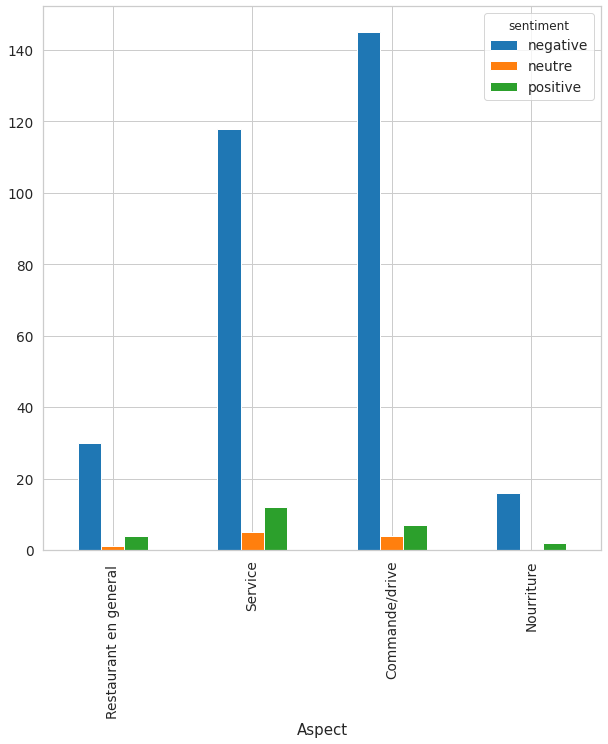

In [265]:
Trutpilot_sentiment = resultFinalWork.groupby(['Aspect', 'sentiment']).sentiment.count().unstack()
Trutpilot_sentiment.plot(kind='bar')

In [0]:
sentiment_model = Sequential()
sentiment_model.add(Dense(512, input_shape=(6000,), activation='relu'))
sentiment_model.add(Dense(218, input_shape=(6000,), activation='relu'))
sentiment_model.add(Dense(64, input_shape=(6000,), activation='relu'))
sentiment_model.add(Dense(3, activation='softmax'))
sentiment_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
sentiment_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(resultFinalWork.sentiment_terms))

In [0]:
label_encoder_2 = LabelEncoder()
integer_sentiment = label_encoder_2.fit_transform(resultFinalWork.sentiment)
dummy_sentiment = to_categorical(integer_sentiment)

In [0]:
sentiment_model.fit(sentiment_tokenized, dummy_sentiment, epochs=5, verbose=1)

Epoch 1/5
344/344 [==============================] - 0s 1ms/step - loss: 0.1397 - accuracy: 0.8983
Epoch 2/5
344/344 [==============================] - 0s 1ms/step - loss: 0.1201 - accuracy: 0.9302
Epoch 3/5
344/344 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9709
Epoch 4/5
344/344 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9855
Epoch 5/5
344/344 [==============================] - 0s 1ms/step - loss: 0.0514 - accuracy: 0.9855


In [0]:
new_review = "mauvais service"

chunks = [(chunk.root.text) for chunk in nlp(new_review).noun_chunks if chunk.root.pos_ == 'NOUN']
new_review_aspect_terms = ' '.join(chunks)
new_review_aspect_tokenized = tokenizer.texts_to_matrix([new_review_aspect_terms])

new_review_category = label_encoder_2.inverse_transform(sentiment_model.predict_classes(new_review_aspect_tokenized))
print(new_review_category)


['negative']


In [0]:
test_reviews = [
    "Bon service rapide.",
    "L'hôtesse était très desagréable.",
    "Le pain était rassis, la salade était trop chère et vide.",
    "La nourriture que nous avons commandée était mauvais, même si je ne dirais pas que les margaritas étaient quelque chose à raconter.",
    "Cet endroit a un décor totalement bizarre, des escaliers avec des murs en miroir - je suis surpris de voir que personne ne s'est encore cassé la tête ou n'est tombé des escaliers"
]

# Aspect preprocessing
test_reviews = [review.lower() for review in test_reviews]
test_aspect_terms = []
for review in nlp.pipe(test_reviews):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    test_aspect_terms.append(' '.join(chunks))
test_aspect_terms = pd.DataFrame(tokenizer.texts_to_matrix(test_aspect_terms))
                             
# Sentiment preprocessing
test_sentiment_terms = []
for review in nlp.pipe(test_reviews):
        if review.is_parsed:
            test_sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            test_sentiment_terms.append('') 
test_sentiment_terms = pd.DataFrame(tokenizer.texts_to_matrix(test_sentiment_terms))

# Models output
test_aspect_categories = label_encoder.inverse_transform(aspect_categories_model.predict_classes(test_aspect_terms))
test_sentiment = label_encoder_2.inverse_transform(sentiment_model.predict_classes(test_sentiment_terms))
for i in range(5):
    print("Review " + str(i+1) + " is expressing a  " + test_sentiment[i] + " opinion about " + test_aspect_categories[i])

Review 1 is expressing a  positive opinion about Service
Review 2 is expressing a  negative opinion about Restaurant en general 
Review 3 is expressing a  negative opinion about Service
Review 4 is expressing a  negative opinion about Commande/drive
Review 5 is expressing a  negative opinion about Commande/drive


# ***Analyse du concurant***


